# Telco Churn

## Project Overview

- Review the Telco's database and find key drivers for customer churn

### Goals

- Identify and hone in on key drivers for customer churn


- Create an effective model to analyze the data and provide accurate predictions


- Provide recommendations based on findings


- Provide key points, explanations and takeaways throughout the process

# Imports

In [1]:
# Standard Imports
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Preparation
from sklearn.model_selection import train_test_split

# Modeling and Evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix

# Statisitcal Testing
import scipy.stats as stats

# Turn off warnings for presentation purposes only
import warnings
warnings.filterwarnings("ignore")

# Acquire & Prepare Files (Wrangle)
from acquire import get_telco_data
from prepare import prep_telco_data
import model as m
import visual as v
import math

# Acquisition

- Data extracted from Telco's SQL Server


- SQL Query netted 7043 rows and 24 columns


- Each row represents a current or churned customer


- Each column represents associated features for each customer

# Preparation

### Under the hood:

- Removed or combined redundant columns or customer features


    - partner + dependents --> family
    - streaming_tv + streaming_movies --> streaming_services
    
    
- Encoded categorical variables


- Reviewed for and replaced `white space` values with `Null` Values


- Removed all `Null` values


    - 11 cells in total, 0.16% of the data
 

- Assumed `tenure` = 0 represents new customers


- Added a column to represent `tenure` in years


- Split the data into three data sets, stratifying on `churn`


    - Train (60%)
    - Validate (25%)
    - Test (15%)

# Preview of the data

In [2]:
# Access the SQL Server to acquire Telco's raw churn data as a dataframe
telco_df = get_telco_data()

# Utilized the preparation script and split the augmented data
train, validate, test = prep_telco_data(telco_df)

# First 5 rows of the dataframe
train.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,senior_citizen,tenure,device_protection,tech_support,paperless_billing,monthly_charges,total_charges,churn,is_male,phone_lines,family,streaming_services,online_services,tenure_years
1341,2,0,2,1998-VHJHK,0,27,0,0,0,19.15,501.35,0,0,1,0,0,0,2
2829,4,0,1,4020-KIUDI,0,6,0,0,0,19.85,138.85,0,1,1,2,0,0,0
1409,1,2,1,2080-CAZNM,1,41,1,0,1,104.40,4133.95,0,0,2,0,2,1,3
5620,3,1,3,7921-BEPCI,0,72,0,0,0,59.75,4265.00,0,0,2,0,0,2,6
4974,2,1,2,6994-ORCWG,0,14,0,0,1,54.25,773.20,0,0,2,0,0,1,1


# Exploration

## What's our current churn?

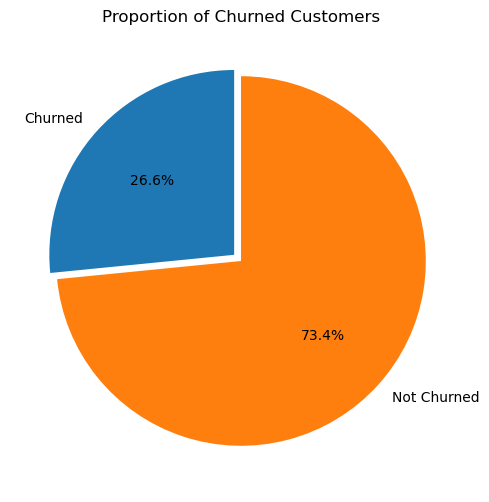

In [3]:
# visual function for churn pie chart
v.churn_pie(train)

## What features have the highest churn density?

### Features with high churn density by population
- `contract_type_id`: 
    - Month-to-Month (24%)
- `tech_support`: 
    - None (22%)
- `paperless_billing`: 
    - Yes (20%)
- `internet_service_type_id`: 
    - Fiber Optic (20%)

### A continuous feature for exploration
- `monthly_charges`

## Hypothesis Testing

### Does Contract Type affect churn?

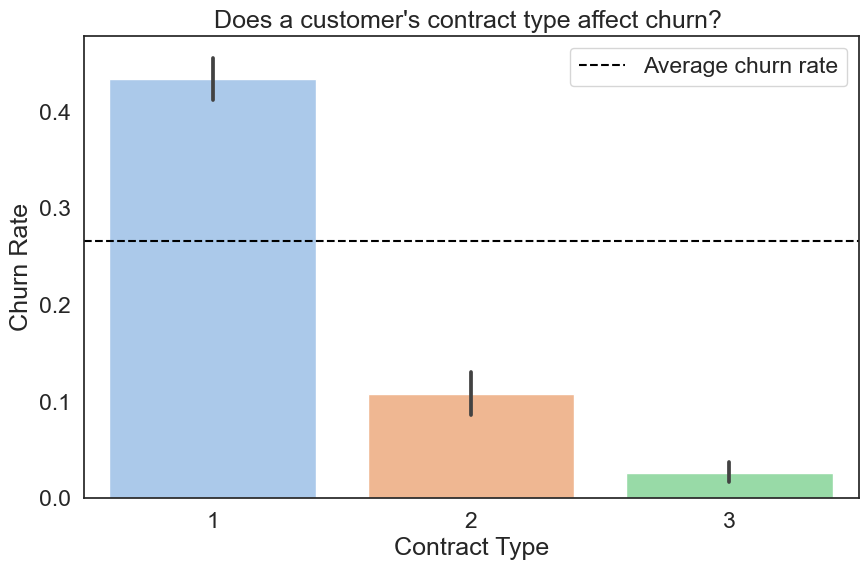

In [4]:
v.contract_type_viz(train)

H$_o$ =  'Churn is independent of Contract Type'

H$_a$ =  'Churn is dependent on Contract Type'

- For this prediction, we will use a Chi Square Test to see if there is a relationship between Contract Type and Churn

In [5]:
# Script for Chi Square Test
v.contract_type_chi(train)

χ^2: 698.857
p-value: 1.75826e-152


- These results indicate that month-to-month contracts are significant driver of churn, and contract_type_id should be used in modeling.

### Is not having Tech Support a key factor in churn?

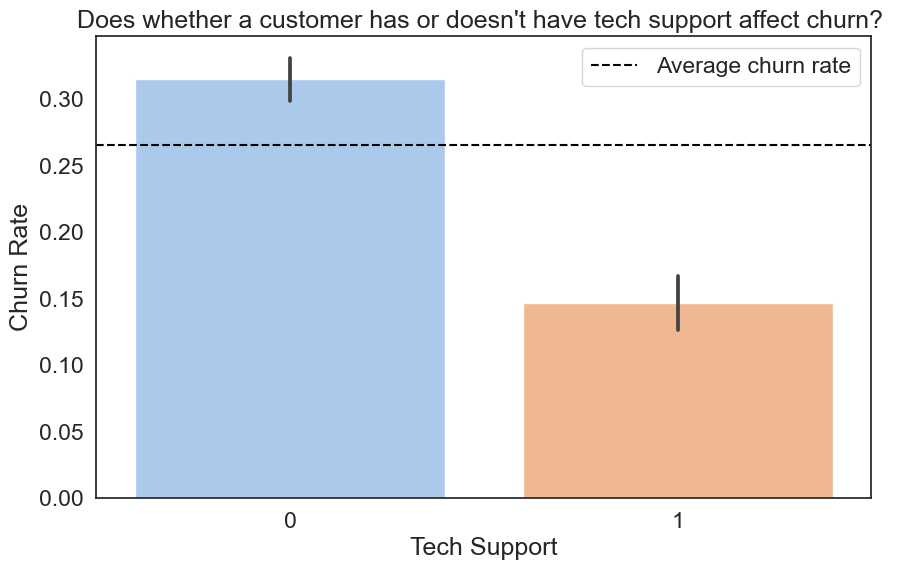

In [6]:
v.tech_support_viz(train)

H$_o$ =  'Not having Tech Support is independent of Churn'

H$_a$ =  'Not having Tech Support is not independent of Churn'

- We will use a Chi Square Test to see if there is a relationship between not having Tech Support and Churn

In [7]:
v.tech_support_chi(train)

χ^2: 117.578
p-value: 2.14493e-27


**With a confidence level p < alpha, we can reject the null hypothesis and say there is evidence that tech support and churn are related.**

Based on the results of this test, I believe that tech support should be used to help with the model's accuracy.

### Are there higher monthly charges for customers driving churn?

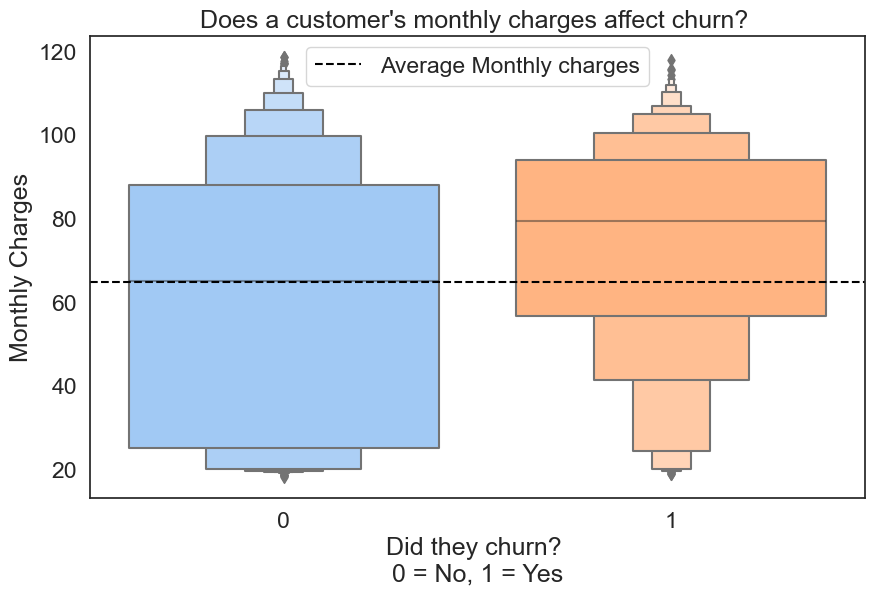

In [8]:
v.monthly_charges_viz(train)


H$_0$ = Average monthly charges of churned customers ≤ average monthly charges of retained customers

H$_a$ = Average monthly charges of churned customers > average monthly charges of retained customers

In [9]:
v.monthly_charges_ttest(train)

tstat: 13.3988
p-value: 1.77491e-39


Since t > 0 and p/2 < alpha we can reject the null hypothesis and say monthly charges of those who churn are higher than those who don't churn.

Based on the visualizations and the results from the T-test, I think that monthly charges should be used in my model to help with the model's accuracy.

## Testing continued

### Does enrolling in paperless billing have an effect on churn?

H$_o$ =  'Paperless billing status is the same between churned and retained customers'

H$_a$ =  'Paperless billing status is not the same between churned and retained customers'

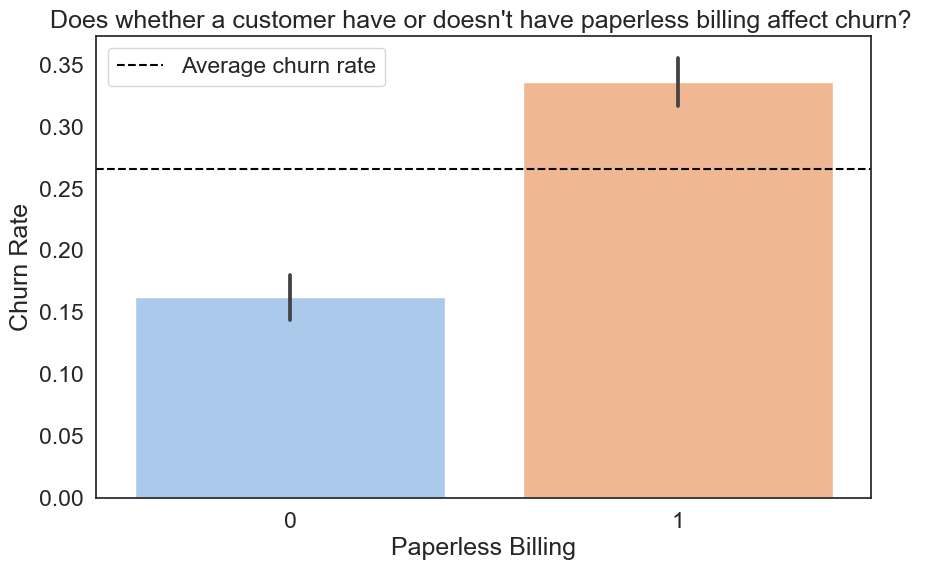

In [10]:
v.paperless_viz(train)

In [11]:
v.paperless_chi(train)

χ^2: 145.776
p-value: 1.45311e-33


### Does the type of internet service customers select influence churn?

H$_o$ =  'Churned customers and retained customers have the same internet services'

H$_a$ =  'Churned customers and retained customers do not have the same internet services'

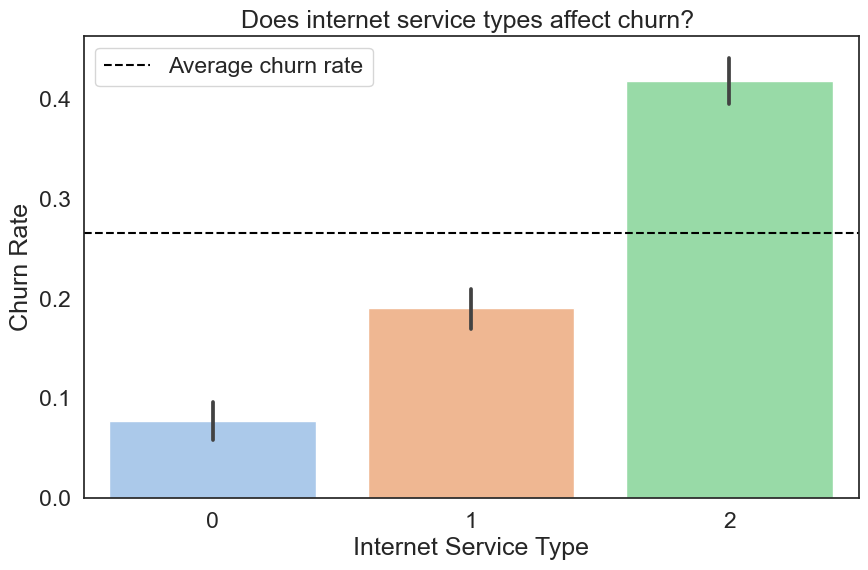

In [12]:
v.internet_viz(train)

In [13]:
v.internet_chi(train)

χ^2: 401.988
p-value: 5.12195e-88


Since t > 0 and p/2 < alpha, we can reject the null hypothesis and say different types of internet services impact churn.

Based on the visualizations and the results from the T-test, I think that internet service types should be used to help with the model's accuracy.

# Modeling

### Baseline

In [14]:
# goal: model > 73.43% in terms of accuracy
v.baseline_acc(train)

0.7343

### Data for Modeling

In [15]:
# Standardized for Modeling

X_train = train[['contract_type_id', 'tech_support', 'paperless_billing', 'internet_service_type_id', 'device_protection', 'monthly_charges']]
y_train = train[['churn']]

X_validate = validate[['contract_type_id', 'tech_support', 'paperless_billing', 'internet_service_type_id', 'device_protection', 'monthly_charges']]
y_validate = validate[['churn']]

X_test = test[['contract_type_id', 'tech_support', 'paperless_billing', 'internet_service_type_id', 'device_protection', 'monthly_charges']]
y_test = test[['churn']]

# Model 1 - Decision Tree

In [16]:
m.decision_tree_results(X_train, y_train, X_validate, y_validate)

Decision Tree
Train Accuracy: 77.83%
Validate Accuracy: 76.90%
Difference: 0.93%


# Model 2 - Random Forest

In [24]:
m.random_forest_results(X_train, y_train, X_validate, y_validate)

Random Forest
Train Accuracy: 77.77%
Validate Accuracy: 77.25%
Difference: 0.52%


# Model 3 - KNN

In [25]:
m.knn_results(X_train, y_train, X_validate, y_validate)

KNN
Train Accuracy: 82.68%
Validate Accuracy: 73.70%
Difference: 8.98%


# Model 4 - Logistic Regression

In [26]:
m.log_results(X_train, y_train, X_validate, y_validate)

Logistic Regression
Train Accuracy: 77.70%
Validate Accuracy: 77.31%
Difference: 0.39%


# Recommended Model

In [30]:
m.best_model_comparison(X_train, y_train, X_validate, y_validate, X_test, y_test)

Random Forest
Train Accuracy: 77.77%
Validate Accuracy: 77.25%
Test Accuracy: 77.68%


In [28]:
m.best_model(X_train, y_train, X_test, y_test)

Best Model: Random Forest
Test Accuracy: 77.68%


# Conclusion

Top Features (Drivers of Churn):
1. contract_type_id
2. tech_support
3. paperless_billing
4. internet_service_type_id
5. monthly_charges       

Best Model:
- Model 2: Random Forest
- More generalizable, not overfit
- Consistency with evaluation metrics of train/validate